### Creating directories for each layer

In [6]:
import os
import pandas as pd

staging_path='Staging_Layer'
mart_path='Mart_Layer'
report_path='Report_Layer'

os.makedirs(staging_path, exist_ok=True)
os.makedirs(mart_path, exist_ok=True)
os.makedirs(report_path, exist_ok=True)

### -------------------------------------Staging Layer-------------------------------------

In [7]:
pip install psycopg2


Note: you may need to restart the kernel to use updated packages.


In [8]:
import psycopg2

# Database connection parameters
conn_params = {
    'dbname': 'postgres',
    'user': 'postgres',
    'password': 'Nasa2003',
    'host': 'localhost',  # or your database host
    'port': '5432'        # default PostgreSQL port
}


try:
    # Establish the connection
    conn = psycopg2.connect(**conn_params)

    # Create a cursor
    cursor = conn.cursor()

    # Fetch employee data
    cursor.execute("SELECT * FROM employees;")
    employee_data = cursor.fetchall()
    employee_columns = [desc[0] for desc in cursor.description]
    employee_df = pd.DataFrame(employee_data, columns=employee_columns)

    # Fetch course data
    cursor.execute("SELECT * FROM courses;")
    course_data = cursor.fetchall()
    course_columns = [desc[0] for desc in cursor.description]
    course_df = pd.DataFrame(course_data, columns=course_columns)

    # Fetch employee_course data
    cursor.execute("SELECT * FROM employee_course;")
    employee_course_data = cursor.fetchall()
    employee_course_columns = [desc[0] for desc in cursor.description]
    employee_course_df = pd.DataFrame(employee_course_data, columns=employee_course_columns)

    # Save to CSV files
    employee_df.to_csv('Staging_Layer/employee.csv', index=False)
    course_df.to_csv('Staging_Layer/course.csv', index=False)
    employee_course_df.to_csv('Staging_Layer/employee_course.csv', index=False)

    print("Data has been successfully exported to CSV files.")

except Exception as e:
    print(f"Error: {e}")

finally:
    # Close the cursor and connection
    if cursor:
        cursor.close()
    if conn:
        conn.close()

Data has been successfully exported to CSV files.


In [9]:
# import pandas as pd
# employee = pd.read_csv('../Source/employee.csv')
# course = pd.read_csv('../Source/courses.csv')
# employee_course = pd.read_csv('../Source/employee_course.csv')

In [10]:
# employee_df = pd.DataFrame(employee)
# course_df = pd.DataFrame(course)
# employee_course_df = pd.DataFrame(employee_course)

In [11]:
# employee_df.to_csv('Staging_Layer/employee.csv', index=False)
# course_df.to_csv('Staging_Layer/course.csv', index=False)
# employee_course_df.to_csv('Staging_Layer/employee_course.csv',index=False)

In [12]:
print(employee_df.info())
print(course_df.info())
print(employee_course_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                500 non-null    int64 
 1   empid             500 non-null    object
 2   name              500 non-null    object
 3   designation       500 non-null    object
 4   password          500 non-null    object
 5   email             500 non-null    object
 6   mobile            500 non-null    int64 
 7   performance_rate  500 non-null    int64 
dtypes: int64(3), object(5)
memory usage: 31.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                50 non-null     int64 
 1   courseid          50 non-null     object
 2   name              50 non-null     object
 3   duration          50 non-null     object
 4

### -------------------------------------Mart Layer------------------------------------

Course Table

In [13]:
course_mart_df = pd.read_csv('Staging_Layer/course.csv')
course_mart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                50 non-null     int64 
 1   courseid          50 non-null     object
 2   name              50 non-null     object
 3   duration          50 non-null     object
 4   difficulty_level  50 non-null     object
 5   learning_path     50 non-null     object
dtypes: int64(1), object(5)
memory usage: 2.5+ KB


In [15]:
course_mart_df.dropna(subset=['courseid'], inplace=True) # Drop rows with null courseID
course_mart_df['name'].fillna('Unknown', inplace=True)  # Filling with 'Unknown' for name
course_mart_df['duration'].fillna('Not Specified', inplace=True)  # Fill with 'Not Specified'
course_mart_df['difficulty_level'].fillna('Not Specified', inplace=True)  # Fill with 'Not Specified'
course_mart_df['learning_path'].fillna('Not Assigned', inplace=True)  # Fill with 'Not Assigned'
course_mart_df=course_mart_df.drop_duplicates() # Dropping duplicate values

C:\Users\AkhilKumar\AppData\Local\Temp\ipykernel_9324\1881581642.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  course_mart_df['name'].fillna('Unknown', inplace=True)  # Filling with 'Unknown' for name
C:\Users\AkhilKumar\AppData\Local\Temp\ipykernel_9324\1881581642.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are 

In [16]:
def convert_duration_to_weeks(duration):
    if isinstance(duration, str):
        # Extract number and convert to weeks based on context
        if 'week' in duration.lower():
            return int(duration.split()[0])  # Returns the numeric part
        elif 'month' in duration.lower():
            return int(duration.split()[0]) * 4  # Assuming 1 month = 4 weeks
        elif 'year' in duration.lower():
            return int(duration.split()[0]) * 52 # Assuming 1 year = 52 weeks
    return None  # For 'Not Specified' or other values

# Apply conversion to a new column for numerical representation
course_mart_df['duration_weeks'] = course_mart_df['duration'].apply(convert_duration_to_weeks)

In [17]:
course_mart_df.to_csv('Mart_Layer/course.csv',index=False)
course_mart_df.head()

,id,courseid,name,duration,difficulty_level,learning_path,duration_weeks
0,1,COURSE001,Technical Writing,6 weeks,Advanced,Data Science,6
1,2,COURSE002,Database Management,2 weeks,Beginner,Cloud Computing,2
2,3,COURSE003,ITIL Foundation,5 weeks,Intermediate,Cloud Computing,5
3,4,COURSE004,Network Security,5 weeks,Beginner,Data Science,5
4,5,COURSE005,Machine Learning Basics,4 weeks,Advanced,Machine Learning,4


Employee_Course Table

In [18]:
employee_course_mart_df=pd.read_csv('Staging_Layer/employee_course.csv')
employee_course_mart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   empid            2000 non-null   object 
 1   courseid         2000 non-null   object 
 2   completion_rate  2000 non-null   float64
dtypes: float64(1), object(2)
memory usage: 47.0+ KB


In [19]:
employee_course_mart_df=employee_course_mart_df.drop_duplicates() # Dropping duplicate values

In [20]:
# Moving data into Mart Layer
employee_course_mart_df.to_csv('Mart_Layer/employee_course.csv', index=False)

Employee Table

In [21]:
employee_mart_df = pd.read_csv('Staging_Layer/employee.csv')
employee_mart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                500 non-null    int64 
 1   empid             500 non-null    object
 2   name              500 non-null    object
 3   designation       500 non-null    object
 4   password          500 non-null    object
 5   email             500 non-null    object
 6   mobile            500 non-null    int64 
 7   performance_rate  500 non-null    int64 
dtypes: int64(3), object(5)
memory usage: 31.4+ KB


In [22]:
# Dropping performance_rate column 
employee_mart_df.drop('performance_rate', axis=1, inplace=True)

# Calculating mean of completion_rates for each employee
mean_completion_rate = employee_course_mart_df.groupby('empid')['completion_rate'].mean().reset_index()

# Rename the completion_rate column to performance_rate for clarity
mean_completion_rate.rename(columns={'completion_rate': 'performance_rate'}, inplace=True)

# Step 2: Merge the mean completion rate back to the employee mart DataFrame
merged_df = employee_mart_df.merge(mean_completion_rate, on='empid', how='left')

# Assign the performance_rate from the merged DataFrame back to employee_mart_df
employee_mart_df['performance_rate'] = merged_df['performance_rate']

employee_mart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                500 non-null    int64  
 1   empid             500 non-null    object 
 2   name              500 non-null    object 
 3   designation       500 non-null    object 
 4   password          500 non-null    object 
 5   email             500 non-null    object 
 6   mobile            500 non-null    int64  
 7   performance_rate  494 non-null    float64
dtypes: float64(1), int64(2), object(5)
memory usage: 31.4+ KB


In [23]:
employee_mart_df.dropna(subset=['empid'], inplace=True)
employee_mart_df['name'].fillna('Unknown',inplace=True)
employee_mart_df['designation'].fillna('Not Known', inplace=True)
employee_mart_df['email'].fillna("Not Known", inplace=True)
employee_mart_df['password'].fillna(employee_mart_df['empid'],inplace=True)
employee_mart_df['mobile'].fillna(0,inplace=True)
employee_mart_df['performance_rate'].fillna(0,inplace=True)
employee_mart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                500 non-null    int64  
 1   empid             500 non-null    object 
 2   name              500 non-null    object 
 3   designation       500 non-null    object 
 4   password          500 non-null    object 
 5   email             500 non-null    object 
 6   mobile            500 non-null    int64  
 7   performance_rate  500 non-null    float64
dtypes: float64(1), int64(2), object(5)
memory usage: 31.4+ KB


C:\Users\AkhilKumar\AppData\Local\Temp\ipykernel_9324\1063586428.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  employee_mart_df['name'].fillna('Unknown',inplace=True)
C:\Users\AkhilKumar\AppData\Local\Temp\ipykernel_9324\1063586428.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a

In [24]:
# Dropping duplicates
employee_mart_df=employee_mart_df.drop_duplicates()

# Rounding performance_rate to two decimals
employee_mart_df['performance_rate'] = employee_mart_df['performance_rate'].round(2)

In [25]:
# Moving data into mart layer
employee_mart_df.to_csv('Mart_Layer/employee.csv')

### -------------------------------------------Report Layer---------------------------------------

In [26]:
fact_df = employee_course_mart_df.merge(course_mart_df, on='courseid', how='left').merge(employee_mart_df, on='empid', how='left')
fact_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   empid             2000 non-null   object 
 1   courseid          2000 non-null   object 
 2   completion_rate   2000 non-null   float64
 3   id_x              2000 non-null   int64  
 4   name_x            2000 non-null   object 
 5   duration          2000 non-null   object 
 6   difficulty_level  2000 non-null   object 
 7   learning_path     2000 non-null   object 
 8   duration_weeks    2000 non-null   int64  
 9   id_y              2000 non-null   int64  
 10  name_y            2000 non-null   object 
 11  designation       2000 non-null   object 
 12  password          2000 non-null   object 
 13  email             2000 non-null   object 
 14  mobile            2000 non-null   int64  
 15  performance_rate  2000 non-null   float64
dtypes: float64(2), int64(4), object(10)
memory

In [27]:
fact_df = fact_df[['empid','designation','courseid','name_x','duration_weeks','difficulty_level','completion_rate','learning_path']]
fact_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   empid             2000 non-null   object 
 1   designation       2000 non-null   object 
 2   courseid          2000 non-null   object 
 3   name_x            2000 non-null   object 
 4   duration_weeks    2000 non-null   int64  
 5   difficulty_level  2000 non-null   object 
 6   completion_rate   2000 non-null   float64
 7   learning_path     2000 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 125.1+ KB


In [28]:
fact_df.rename(columns={'name_x':'course_name'}, inplace=True)
fact_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   empid             2000 non-null   object 
 1   designation       2000 non-null   object 
 2   courseid          2000 non-null   object 
 3   course_name       2000 non-null   object 
 4   duration_weeks    2000 non-null   int64  
 5   difficulty_level  2000 non-null   object 
 6   completion_rate   2000 non-null   float64
 7   learning_path     2000 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 125.1+ KB


In [29]:
fact_df.to_csv('Report_Layer/fact.csv', index=False)
fact_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   empid             2000 non-null   object 
 1   designation       2000 non-null   object 
 2   courseid          2000 non-null   object 
 3   course_name       2000 non-null   object 
 4   duration_weeks    2000 non-null   int64  
 5   difficulty_level  2000 non-null   object 
 6   completion_rate   2000 non-null   float64
 7   learning_path     2000 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 125.1+ KB


### --------------------------------------Visualizations-------------------------------------

C:\Users\AkhilKumar\AppData\Local\Temp\ipykernel_9324\2960668782.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='course_name', y='completion_rate', data=avg_completion_rate, palette='viridis')


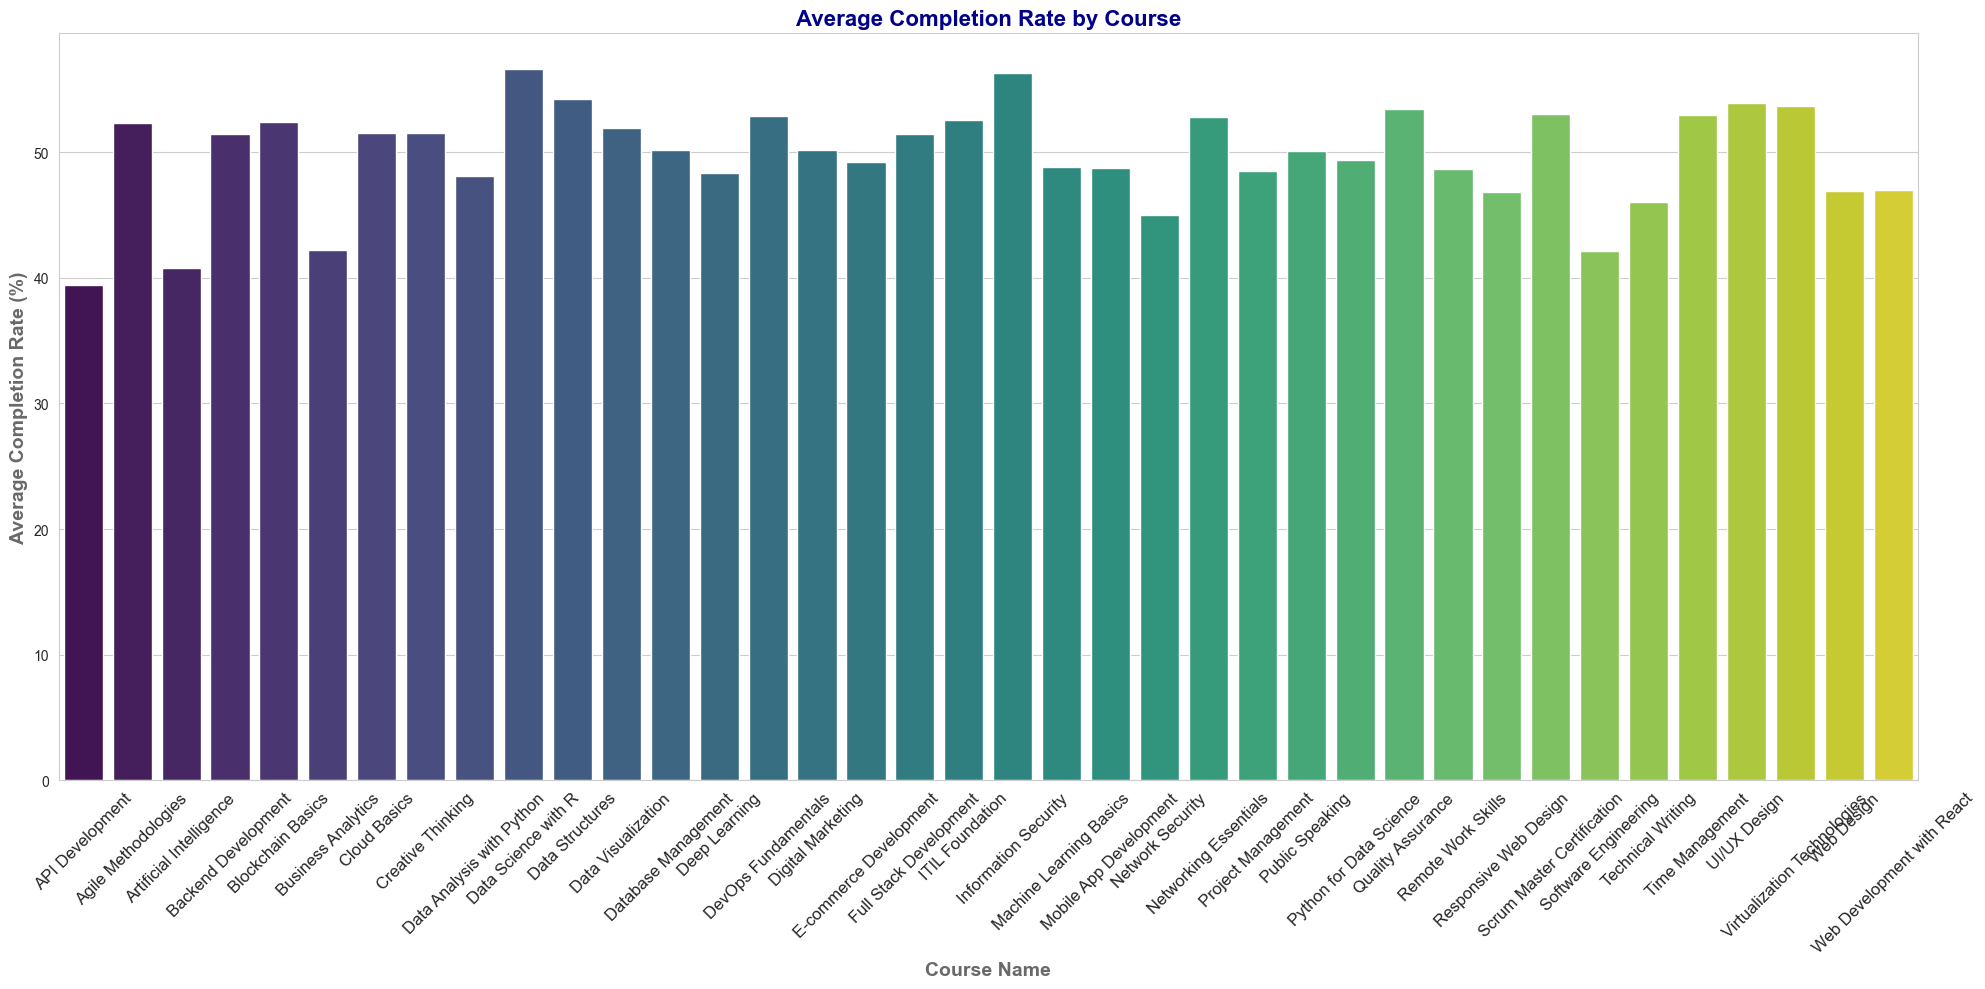

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming fact_df is your DataFrame
avg_completion_rate = fact_df.groupby('course_name')['completion_rate'].mean().reset_index()

# Set the style
sns.set_style("whitegrid")  # or "darkgrid" for a darker background
plt.figure(figsize=(20, 10))

# Create the bar plot
bar_plot = sns.barplot(x='course_name', y='completion_rate', data=avg_completion_rate, palette='viridis')

# Add title and labels
plt.title('Average Completion Rate by Course', fontsize=16, fontweight='bold', color='darkblue')
plt.xlabel('Course Name', fontsize=14, fontweight='bold', color='dimgray')
plt.ylabel('Average Completion Rate (%)', fontsize=14, fontweight='bold', color='dimgray')

# Rotate x-tick labels for better readability
plt.xticks(rotation=45, fontsize=12)

# Customize the layout
plt.tight_layout()

# Show the plot
plt.show()


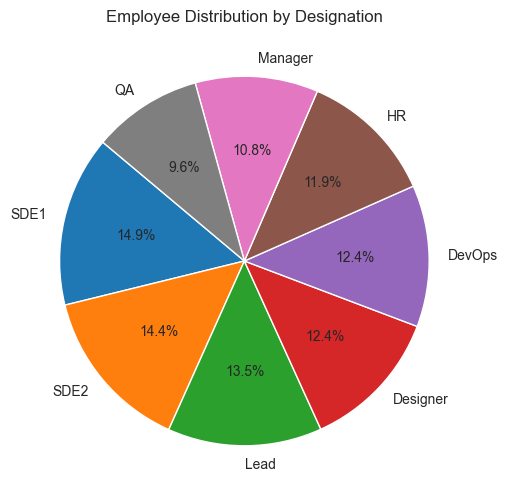

In [31]:
plt.figure(figsize=(6, 6))
fact_df['designation'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140)
plt.title('Employee Distribution by Designation')
plt.ylabel('')
plt.show()

C:\Users\AkhilKumar\AppData\Local\Temp\ipykernel_9324\2910956495.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


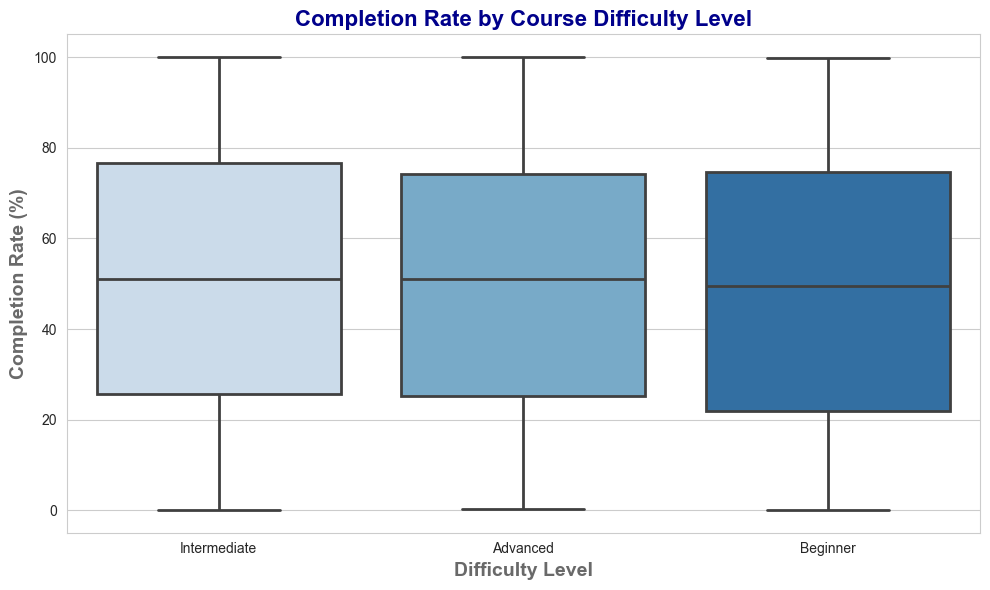

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
sns.set_style("whitegrid")

# Create the figure
plt.figure(figsize=(10, 6))

# Create the boxplot with improved aesthetics
sns.boxplot(
    x='difficulty_level', 
    y='completion_rate', 
    data=fact_df, 
    palette='Blues',  # Set color palette
    linewidth=2,  # Thicker line for box edges
    fliersize=4  # Smaller outliers to reduce distraction
)

# Add title and labels with improved formatting
plt.title('Completion Rate by Course Difficulty Level', fontsize=16, fontweight='bold', color='darkblue')
plt.xlabel('Difficulty Level', fontsize=14, fontweight='bold', color='dimgray')
plt.ylabel('Completion Rate (%)', fontsize=14, fontweight='bold', color='dimgray')

# Show the plot
plt.tight_layout()
plt.show()


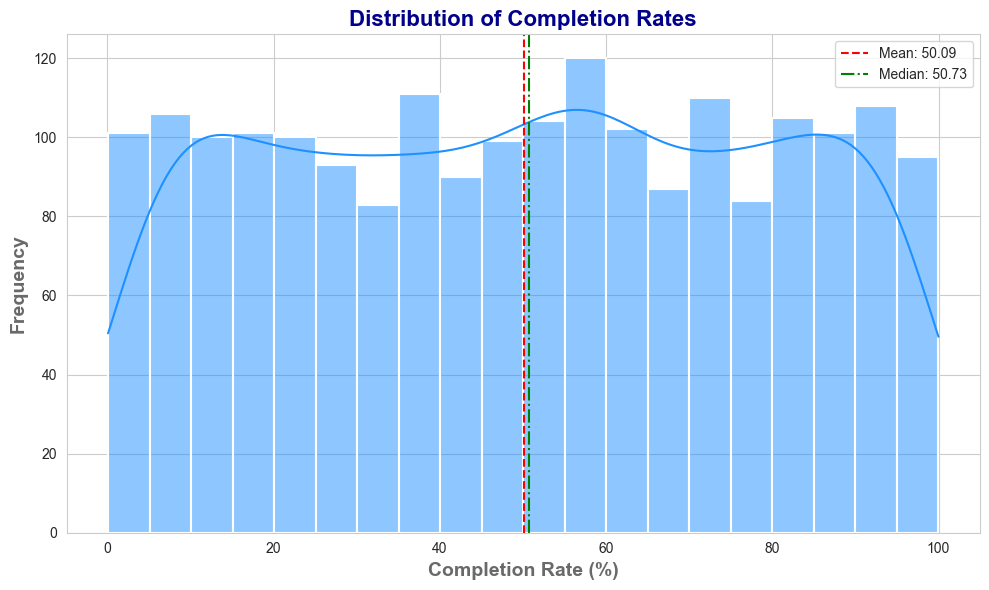

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set the style
sns.set_style("whitegrid")

# Create the figure
plt.figure(figsize=(10, 6))

# Create the histogram with KDE (Kernel Density Estimate) for a smooth curve
sns.histplot(
    fact_df['completion_rate'], 
    bins=20, 
    kde=True,  # Kernel Density Estimate line
    color='dodgerblue',  # Color for the histogram bars
    edgecolor='white',  # White edges for the bars
    linewidth=1.5  # Line width for the bar edges
)

# Add mean and median lines
mean_rate = fact_df['completion_rate'].mean()
median_rate = fact_df['completion_rate'].median()
plt.axvline(mean_rate, color='red', linestyle='--', label=f'Mean: {mean_rate:.2f}')
plt.axvline(median_rate, color='green', linestyle='-.', label=f'Median: {median_rate:.2f}')

# Add title and axis labels with improved formatting
plt.title('Distribution of Completion Rates', fontsize=16, fontweight='bold', color='darkblue')
plt.xlabel('Completion Rate (%)', fontsize=14, fontweight='bold', color='dimgray')
plt.ylabel('Frequency', fontsize=14, fontweight='bold', color='dimgray')

# Add a legend for the mean and median lines
plt.legend()

# Show the plot with a tight layout
plt.tight_layout()
plt.show()


C:\Users\AkhilKumar\AppData\Local\Temp\ipykernel_9324\1135266178.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='learning_path', y='completion_rate', data=learning_path_completion, ci=None, palette="Blues")
C:\Users\AkhilKumar\AppData\Local\Temp\ipykernel_9324\1135266178.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='learning_path', y='completion_rate', data=learning_path_completion, ci=None, palette="Blues")


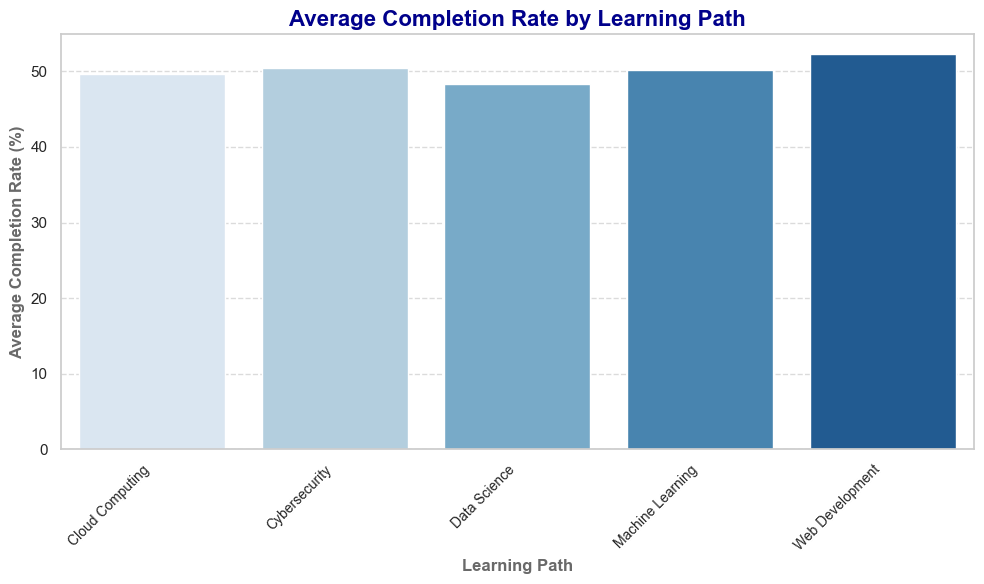

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate average completion rate by learning path
learning_path_completion = fact_df.groupby('learning_path')['completion_rate'].mean().reset_index()

# Set the figure size and style
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Create a barplot with a cool color palette
sns.barplot(x='learning_path', y='completion_rate', data=learning_path_completion, ci=None, palette="Blues")

# Add title and labels with more customization
plt.title('Average Completion Rate by Learning Path', fontsize=16, fontweight='bold', color='darkblue')
plt.xlabel('Learning Path', fontsize=12, fontweight='bold', color='dimgray')
plt.ylabel('Average Completion Rate (%)', fontsize=12, fontweight='bold', color='dimgray')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=10)

# Add gridlines to the y-axis for clarity
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------